
В ходе исследования в первую очередь мы сделаем предобработку данных для анализа - посмотрим на дубликаты и пропущенные значения, проверим регистр в названиях столбцов, а также проверим корректность типов данных. 

Также проведем исследовательский анализ данных, то есть сделаем некоторую визуализацию и посмотрим на взаимосвязи разных параметров в данных. 

Далее попробуем составить типичный портрет пользователя для каждого региона и проверим пару гипотез, которые смогут помочь нам сделать правильные выводы.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

##  Загрузка и обзор данных

In [3]:
# выведем первые 5 строк датафрейма 
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# изучим основную информацию о датафрейме
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


После первичного знакомства с данными можно сказать, что количество строк в столбцах различается, что говорит о наличии пропущенных значений. Названия столбцов необходимо привести к нижнему регистру. Столбец Year_of_Release стоит привести к целому типу данных, а столбец User_Score - к вещественному типу. 

## Предобработка данных


На этом этапе нашей задачей будет подготовить данные для анализа - проверим именование столбцов, отсутствующие значения в данных и найдем дубликаты.

### Замена названий столбцов

In [5]:
# приведем названия столбцов к нижнему регистру
games.columns = games.columns.str.lower()
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Обработка пропусков

In [6]:
# определим, в каких столбцах есть пропуски и их долю
games.isna().mean()

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

In [7]:
# посмотрим на строки, где пропущено название игры
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Так как мы ищем закономерности, определяющие успешность игры, то без названия эти данные не представляют никакой значимости, поэтому уберем их из датасета. Точно также данные без года не пригодны для анализа, удалим строки из датасета.

In [8]:
# удалим строки с пропусками в столбцах name и year_of_release
games = games.dropna(subset=['name', 'year_of_release'])

In [9]:
games.isna().mean()

name               0.000000
platform           0.000000
year_of_release    0.000000
genre              0.000000
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.514534
user_score         0.401666
rating             0.405984
dtype: float64

Остались пропуски в оценках. У половины игр отсутствует оценка критиков в столбце `critic_score`, у 40% игр - пропуски в оценках пользователей, это данные `user_score`, а также не определена подходящая возрастная категория для 40% игр.

In [10]:
# посмотрим на уникальные значения столбца rating
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)


Добавим заглушку на пропуски в данных с рейтингом ESRB - пусть это будут значения "No" - тоже значение с типом данных object.

In [11]:
# поставим заглушку на пропуски
games['rating'] = games['rating'].fillna('No') 


Таким образом, мы удалили пропуски в столбцах c названием игры и годом выпуска, так как без них данные не представляют никакой значимости, а мы ищем факторы, опеределяюшие успешность игры. <br>
    Пропуски в оценках пользователей и критиков мы не сможем заполнить самостоятельно, поэтому оставим их без изменения. Здесь они могут быть связаны с тем, что оценка еще не была получена и ожидала получения в будущем. <br>
    Также нашли пропущенные значения в рейтинге  ESRB и заменили на значение "No". Здесь они связаны с тем, что организация определяет рейтинги для компьютерных видеоигр только в США и Канаде, а мы имеем данные и для Европы, и для рынка Японии.


### Преобразование данных в нужные типы

In [12]:
# преобразуем год выпуска к целому типу данных
games['year_of_release'] = games['year_of_release'].astype('Int64')

In [13]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No


In [14]:
# проверим, какой период охватывают данные
games["year_of_release"].min(), games["year_of_release"].max()

(1980, 2016)

In [15]:
# посмотрим на уникальные значения столбца user_score
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [16]:
games['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.6       2
1.5       2
1.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

Большинство игр имеют оценку tbd. Вероятно, это to be determined - то есть то, что будет определено в будущем.  Мы не сможем определить оценку для этих игр, но значение мешает для выполнения операций. Заменим tbd значение на NaN и преобразуем к типу данных float.

In [17]:
# преобразуем данные по рейтингу пользователей к вещественному типу 
games['user_score'] = games['user_score'].replace('tbd', np.nan)
games['user_score'] = pd.to_numeric(games['user_score'])
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           16444 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


### Обработка явных и неявных дубликатов


Проверим данные также на наличие явных и неявных дубликатов. 


In [18]:
# проверим на наличие явных дубликатов
games.duplicated().sum()

0


Явных дубликатов в данных нет, теперь проверим неявные по отдельным столбцам, а также по трем параметрам одновременно - по имени, платформе и году релиза.


In [19]:
# посмотрим на уникальные названия платформ
games['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [20]:
# посмотрим на уникальные названия игр
games['name'].value_counts()

Need for Speed: Most Wanted                           12
Ratatouille                                            9
LEGO Marvel Super Heroes                               9
FIFA 14                                                9
LEGO Jurassic World                                    8
                                                      ..
Chou!! Super Nep League DS                             1
Chou-Kuukan Night Pro Yakyuu King(higher JP sales)     1
300: March to Glory                                    1
Mario vs. Donkey Kong: Mini-Land Mayhem!               1
Justice League Heroes: The Flash                       1
Name: name, Length: 11426, dtype: int64

In [21]:
# проверим на наличие неявных дубликатов по имени, платформе и году релиза одновременно
games[games.duplicated(['name', 'platform', 'year_of_release'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E



Нашли 2 строки с одинаковыми значениями в указанных параметрах. Первая строка содержит более полную информацию, оставим ее в датасете.


In [22]:
games = games.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first')
games.duplicated(['name', 'platform', 'year_of_release']).sum()

0


Дубликатов больше нет.


### Cуммарные продажи во всех регионах

In [23]:
# посчитаем суммарные продажи во всех регионах и запишем в отдельный столбец total_sales
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,No,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,No,31.38


In [24]:
# Посмотрим, что осталось
temp = games.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       7462 non-null   float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
n

## Исследовательский анализ


На этом этапе проведем исследовательский анализ данных - посмотрим, сколько игр выпускалось в разные годы, посчитаем суммарные продажи по платформам и выделим самые прибыльные, определим релевантный период для анализа и посмотрим на взаимосвязи между разными параметрами.

### Количество игр с выпуском по годам

In [25]:
# посмотрим, сколько игр выпускалось в разные годы
year_pivot_table = games.pivot_table(
    values="name", index="year_of_release", aggfunc="count"
).sort_values(by='name', ascending=False).reset_index()
year_pivot_table.head()

,year_of_release,name
0,2008,1427
1,2009,1426
2,2010,1255
3,2007,1197
4,2011,1136


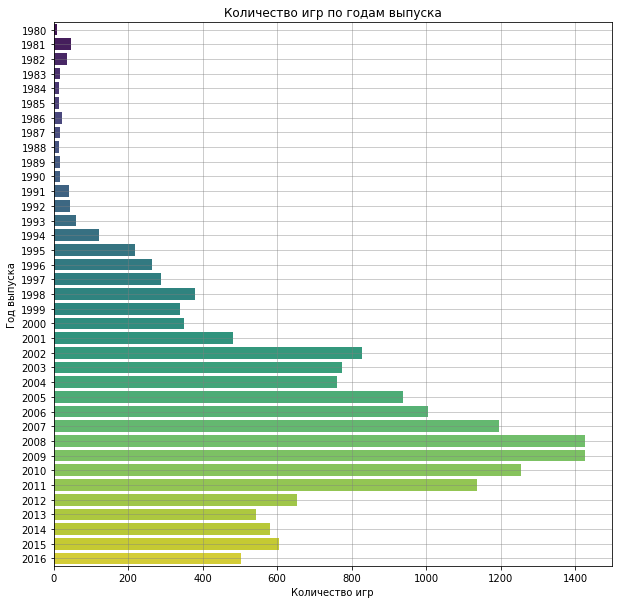

In [26]:
# посмотрим данные на графике
plt.figure(figsize=(10, 10))
sns.barplot(x=year_pivot_table["name"], y=year_pivot_table["year_of_release"], palette="viridis", orient="h")
plt.title("Количество игр по годам выпуска")
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Количество игр")
plt.ylabel("Год выпуска")
plt.show()

Можно заметить, что до 1994 года выпускалось очень мало игр, график имеет скошенный вид. Эти данные могут быть не так важны.

In [27]:
# посмотрим, сколько игр выпускалось до 1994 года
year_pivot_table[year_pivot_table["year_of_release"] < 1994].count()

year_of_release    14
name               14
dtype: int64

Всего 14 игр до 1994 года.

### Cуммарные продажи по платформам

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам. 

In [28]:
# посчитаем суммарные продажи по платформам и определим топ-5
platform_pivot = games.pivot_table(
    values="total_sales", index="platform", aggfunc="sum"
).sort_values(by='total_sales', ascending=False).reset_index()
platform_pivot.head()

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.33
3,Wii,891.18
4,DS,802.78


In [29]:
platform_sales = games.groupby(["year_of_release", "platform"]).agg(
    {
        "total_sales": "sum"
    }
).sort_values(by='total_sales', ascending=False).reset_index()
platform_sales.head()

,year_of_release,platform,total_sales
0,2004,PS2,211.81
1,2009,Wii,206.97
2,2002,PS2,205.38
3,2003,PS2,184.31
4,2008,Wii,171.32


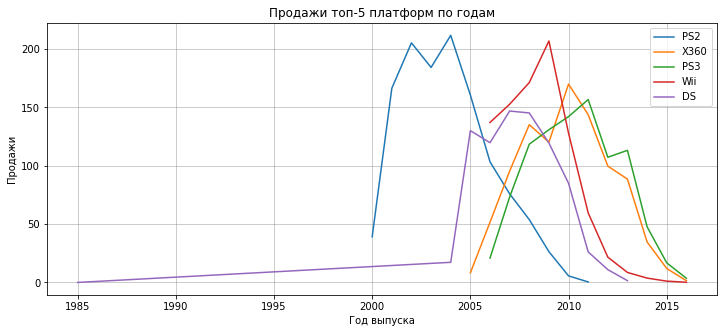

In [30]:
# посмотрим наглядно на графике
plt.figure(figsize=(12, 5))
sns.lineplot(data=platform_sales[platform_sales['platform'] == 'PS2'], x="year_of_release", y="total_sales", label='PS2')
sns.lineplot(data=platform_sales[platform_sales['platform'] == 'X360'], x="year_of_release", y="total_sales", label='X360')
sns.lineplot(data=platform_sales[platform_sales['platform'] == 'PS3'], x="year_of_release", y="total_sales", label='PS3')
sns.lineplot(data=platform_sales[platform_sales['platform'] == 'Wii'], x="year_of_release", y="total_sales", label='Wii')
sns.lineplot(data=platform_sales[platform_sales['platform'] == 'DS'], x="year_of_release", y="total_sales", label='DS')
plt.title("Продажи топ-5 платформ по годам")
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Год выпуска")
plt.ylabel("Продажи")
plt.show()

По графику видно, что каждая платформа в среднем имеет цикл 10 лет - за это время она появляется, набирает обороты и затем исчезает. Исключением является DS, которая функционировала с 1985 года, но продажи были низкими. Одна платформа угасает, а другая появляется в среднем на 3-4 года. В связи с этим, определим актуальный период как 3 года и  возьмем данные только за период с 2014 по 2016 год.

### Определение актуального периода для анализа

Для анализа нам понадобится не весь датасет, а только актуальный период. Посчитаем срок жизни платформ.

In [31]:
# Комментарий ревьюера
temp = games.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

In [32]:
# возьмем только данные после 2013 года
games_upd = games[games['year_of_release'] > 2013]

### Самые прибыльные платформы

На этом этапе посмотрим, какие платформы лидируют по продажам, растут или падают за указанный период.

In [33]:
# посмотрим, какие платформы были самыми прибыльными за последние 3 года
top_platform_pivot = games_upd.pivot_table(
    values="total_sales", index="platform", aggfunc="sum"
).sort_values(by='total_sales', ascending=False).reset_index()
top_platform_pivot.head()

,platform,total_sales
0,PS4,288.15
1,XOne,140.36
2,3DS,86.68
3,PS3,68.18
4,X360,48.22


In [34]:
# добавим в сводную таблицу также год
top_platform_pivot = games_upd.pivot_table(
    values="total_sales", index=["platform", "year_of_release"], aggfunc="sum"
).sort_values(by='total_sales', ascending=False).reset_index()
top_platform_pivot.head()

,platform,year_of_release,total_sales
0,PS4,2015,118.90
1,PS4,2014,100.00
2,PS4,2016,69.25
3,XOne,2015,60.14
4,XOne,2014,54.07


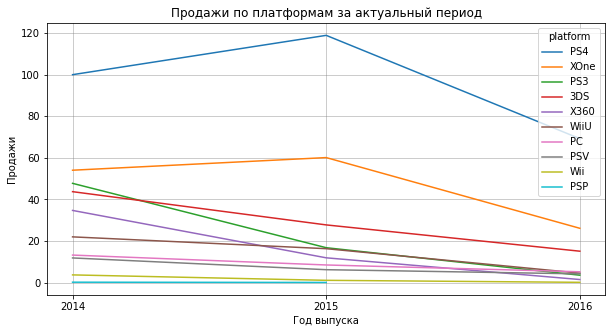

In [35]:
# посмотрим на динамику продаж по платформам на графике
plt.figure(figsize=(10, 5))
sns.lineplot(x='year_of_release', y='total_sales', hue='platform', data=top_platform_pivot)
plt.title('Продажи по платформам за актуальный период')
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Год выпуска")
plt.ylabel("Продажи")
plt.xticks([2014, 2015, 2016])
plt.show()

По графику видно, что за последние 3 года платформы становились менее популярными, продажи падали. Наиболее прибыльными были PS4, XOne и 3DS.

### «Ящик с усами» по глобальным продажам игр в разбивке по платформам

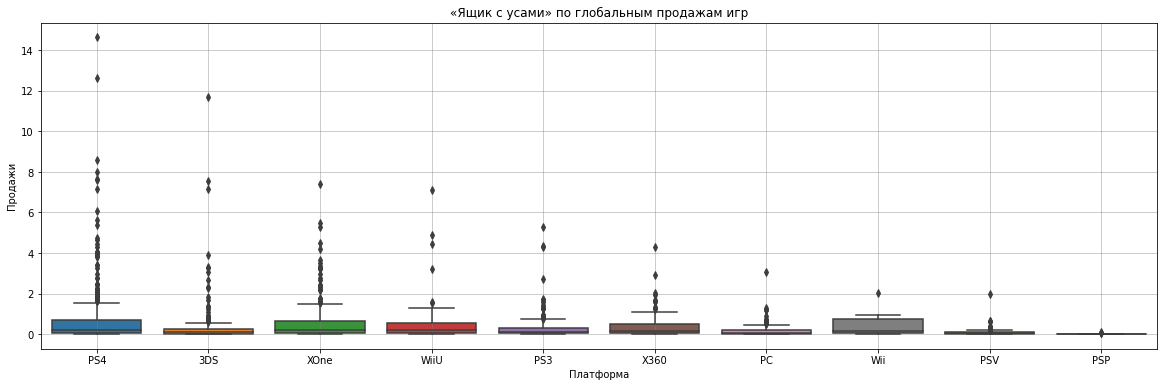

In [37]:
# построим  «ящик с усами» по глобальным продажам игр в разбивке по платформам
plt.figure(figsize=(20, 6))
sns.boxplot(y='total_sales', x='platform', data=games_upd)
plt.title('«Ящик с усами» по глобальным продажам игр')
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.show()

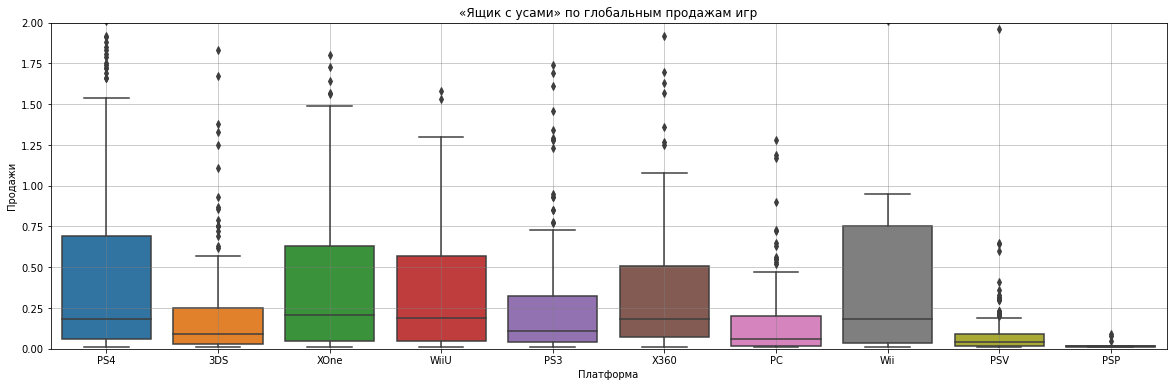

In [38]:
# масштабируем график
plt.figure(figsize=(20, 6))
sns.boxplot(y='total_sales', x='platform', data=games_upd)
plt.title('«Ящик с усами» по глобальным продажам игр')
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.ylim(0, 2)
plt.show()

По графику видно, что на всех платформам (кроме Wii) большой разброс продаж и есть выбросы. <br>
    Можно сделать вывод, что на платформах PS4, XOne, WiiU, X360 и Wii больше топовых игр, так как медианы графиков имеют наибольшие значения. Платформы PSP, PSV и PC представляют меньший интерес, так как медианы имеют маленькие значения, что говорит о более низких средних продажах. 

### Определение влияния отзывов критиков и пользователей на продажи 


Построим диаграммы рассеяния для наиболее популярных платформ и посчитаем корреляцию между отзывами и продажами.

In [39]:
# отфильтруем данные для платформы PS4
ps_four_data = games_upd[games_upd['platform'] == 'PS4']
ps_four_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,No,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,No,7.98
92,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016,Adventure,0.00,0.00,0.01,0.00,69.0,7.5,No,0.01
16503,Shin Hayarigami 2,PS4,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,No,0.01
16526,Dungeons 2,PS4,2016,Role-Playing,0.01,0.00,0.00,0.00,61.0,7.9,T,0.01
16530,Carmageddon: Max Damage,PS4,2016,Action,0.01,0.00,0.00,0.00,51.0,5.5,M,0.01


Посмотрим, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков.

,total_sales,critic_score,user_score
total_sales,1.000000,0.402661,-0.040132
critic_score,0.402661,1.000000,0.546434
user_score,-0.040132,0.546434,1.000000


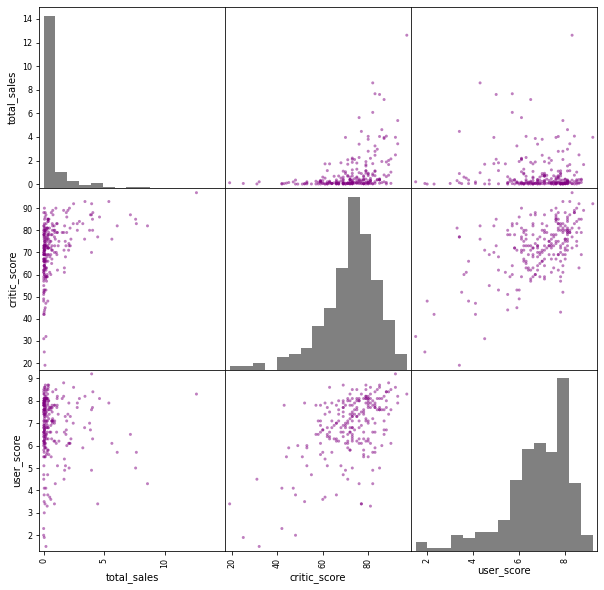

In [40]:
# построим матрицу рассеяния и оценим коэффициент Пирсона для PS4
ps_four_corr = ps_four_data[["total_sales", "critic_score", "user_score"]]
pd.plotting.scatter_matrix(ps_four_corr, color='purple', hist_kwds={'bins':15, 'color':'grey'}, figsize=(10, 10))
ps_four_corr.corr()

Построим диаграмму рассеяния для PS4 и посчитаем корреляцию между отзывами и продажами.

0.40266141068104083
-0.040131589472697356


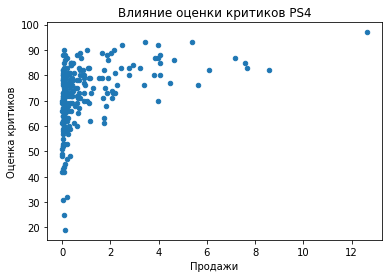

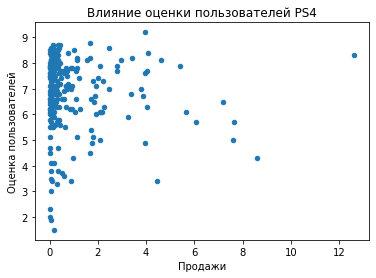

In [41]:
#построим диаграммы рассеяния для PS4 
ps_four_data.plot(x='total_sales', y='critic_score', kind='scatter')
plt.title('Влияние оценки критиков PS4')
plt.xlabel("Продажи")
plt.ylabel("Оценка критиков")
print(ps_four_data['total_sales'].corr(ps_four_data['critic_score']))
ps_four_data.plot(x='total_sales', y='user_score', kind='scatter')
plt.title('Влияние оценки пользователей PS4')
plt.xlabel("Продажи")
plt.ylabel("Оценка пользователей")
print(ps_four_data['total_sales'].corr(ps_four_data['user_score']))
plt.show()

Коэффициент равный 0.40 говорит о наличии положительной корреляции между оценкой критиков и продажами, однако не слишком сильной. Выходит, увеличение оценки критиков сопровождается ростом продаж, но так бывает не всегда.

Коэффициент -0.04 характеризует очень слабую отрицательную корреляцию. Скорее всего, особой связи между отзывыми пользователей и продажами нет.


Диаграмма рассеяния и рассчитанные коэффициенты говорят о том, что нет значительной корреляции между оценкой критиков и продажами.

,total_sales,critic_score,user_score
total_sales,1.000000,0.428677,-0.070384
critic_score,0.428677,1.000000,0.440977
user_score,-0.070384,0.440977,1.000000


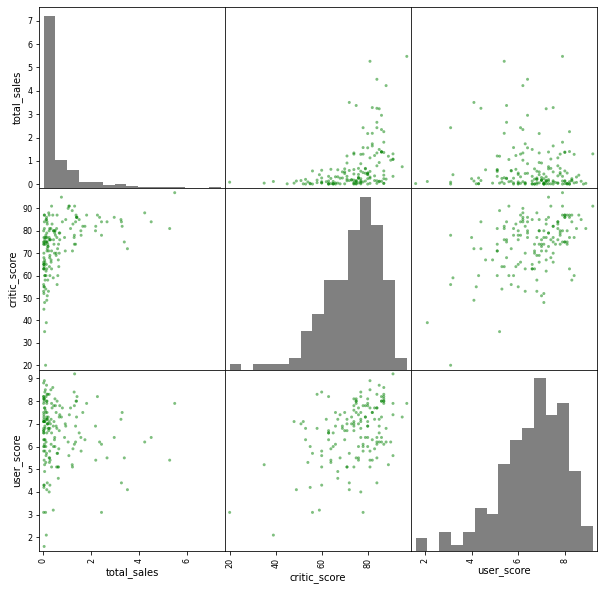

In [42]:
# построим диаграмму рассеяния и оценим коэффициент Пирсона для XOne
xone_data = games_upd[games_upd['platform'] == 'XOne']
xone_data_corr = xone_data[["total_sales", "critic_score", "user_score"]]
pd.plotting.scatter_matrix(xone_data_corr, color='green', hist_kwds={'bins':15, 'color':'grey'}, figsize=(10, 10))
xone_data_corr.corr()


Построим диаграмму рассеяния для XOne и посчитаем корреляцию между отзывами и продажами.

0.42867694370333226
-0.0703839280647581


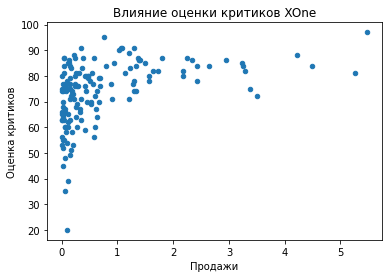

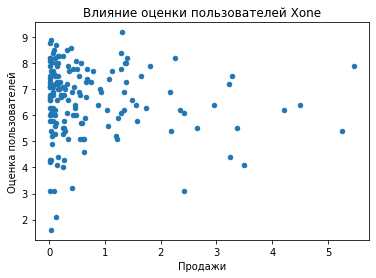

In [43]:
#построим диаграммы рассеяния для Xone
xone_data.plot(x='total_sales', y='critic_score', kind='scatter')
plt.title('Влияние оценки критиков XOne')
plt.xlabel("Продажи")
plt.ylabel("Оценка критиков")
print(xone_data['total_sales'].corr(xone_data['critic_score']))
xone_data.plot(x='total_sales', y='user_score', kind='scatter')
plt.title('Влияние оценки пользователей Xone')
plt.xlabel("Продажи")
plt.ylabel("Оценка пользователей")
print(xone_data['total_sales'].corr(xone_data['user_score']))
plt.show()

Ситуация схожа с платформой PS4. Коэффициент равный 0.42 говорит о наличии положительной корреляции между оценкой критиков и продажами, однако не слишком сильной. Коэффициент -0.07 говорит об отсутствии связи между отзывами пользователей и продажами, либо слишком слабой.

,total_sales,critic_score,user_score
total_sales,1.000000,0.314117,0.215193
critic_score,0.314117,1.000000,0.862485
user_score,0.215193,0.862485,1.000000


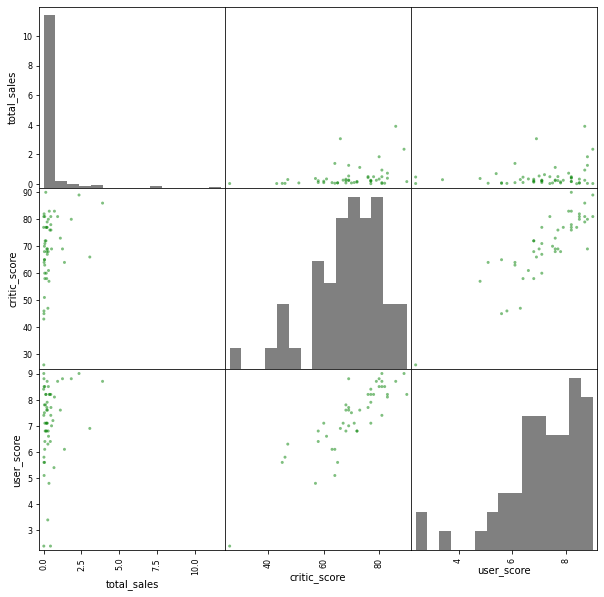

In [44]:
# построим диаграмму рассеяния и оценим коэффициент Пирсона для 3DS
three_ds_data = games_upd[games_upd['platform'] == '3DS']
three_ds_data_corr = three_ds_data[["total_sales", "critic_score", "user_score"]]
pd.plotting.scatter_matrix(three_ds_data_corr, color='green', hist_kwds={'bins':15, 'color':'grey'}, figsize=(10, 10))
three_ds_data_corr.corr()

По матрицам рассеяния можем сделать вывод, что по двум другим платформам ситуация схожа с PS4. По XOne коэффициенты корреляции близки к коэффициентам по PS4, а по 3DS связь еще слабее. 

Посмотрим на данные платформы Wii.

In [45]:
wii_data = games_upd[games_upd['platform'] == 'Wii']
wii_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 850 to 16312
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             11 non-null     object 
 1   platform         11 non-null     object 
 2   year_of_release  11 non-null     Int64  
 3   genre            11 non-null     object 
 4   na_sales         11 non-null     float64
 5   eu_sales         11 non-null     float64
 6   jp_sales         11 non-null     float64
 7   other_sales      11 non-null     float64
 8   critic_score     0 non-null      float64
 9   user_score       2 non-null      float64
 10  rating           11 non-null     object 
 11  total_sales      11 non-null     float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.1+ KB


Мы видим, что данные по отзывам пользователей и критиков отсутствуют, поэтому установить корреляцию по этой платформе не представляется возможным. Посмотрим на данные платформы WiiU.

In [46]:
wiiu_data = games_upd[games_upd['platform'] == 'WiiU']
wiiu_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73 entries, 110 to 16652
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             73 non-null     object 
 1   platform         73 non-null     object 
 2   year_of_release  73 non-null     Int64  
 3   genre            73 non-null     object 
 4   na_sales         73 non-null     float64
 5   eu_sales         73 non-null     float64
 6   jp_sales         73 non-null     float64
 7   other_sales      73 non-null     float64
 8   critic_score     43 non-null     float64
 9   user_score       48 non-null     float64
 10  rating           73 non-null     object 
 11  total_sales      73 non-null     float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 7.5+ KB


0.370201412480884
0.4079264579217078


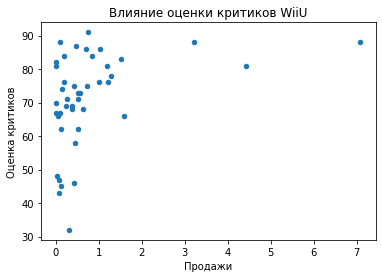

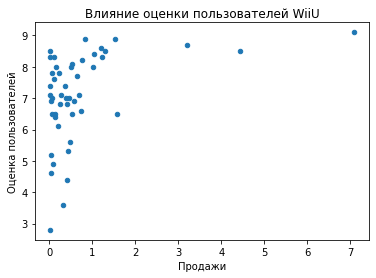

In [47]:
#построим диаграммы рассеяния для WiiU
wiiu_data.plot(x='total_sales', y='critic_score', kind='scatter')
plt.title('Влияние оценки критиков WiiU')
plt.xlabel("Продажи")
plt.ylabel("Оценка критиков")
print(wiiu_data['total_sales'].corr(wiiu_data['critic_score']))
wiiu_data.plot(x='total_sales', y='user_score', kind='scatter')
plt.title('Влияние оценки пользователей WiiU')
plt.xlabel("Продажи")
plt.ylabel("Оценка пользователей")
print(wiiu_data['total_sales'].corr(wiiu_data['user_score']))
plt.show()

Здесь коэффициент Пирсона для оценки пользоваталей имеет более высокое значение 0.40 и говорит о наличии связи, однако по-прежнему не слишком сильной.

В результате проведенного анализа можно сделать вывод, что отзывы критиков могут оказывать влияние на продажи по платформам, но так бывает не всегда. Отзывы пользователей имеют еще более слабую связь с продажами. 

### Общее распределение игр по жанрам

Теперь посмотрим на общее распределение игр по жанрам. 

In [49]:
genres_pivot = games_upd.pivot_table(
    values="total_sales", index="genre", aggfunc=['sum', 'median']
).sort_values(by=('median', 'total_sales'), ascending=False).reset_index()
genres_pivot.head(10)

,genre,sum,median
,,total_sales,total_sales
0,Shooter,170.94,0.515
1,Sports,109.48,0.180
2,Platform,18.09,0.140
3,Fighting,28.22,0.125
4,Role-Playing,101.44,0.110
5,Simulation,13.13,0.100
6,Action,199.36,0.090
7,Misc,37.55,0.090
8,Racing,27.52,0.090


По общим продажам видно, что есть среди различных жанров есть явные лидеры. 

>- Самые высокие продажи у игр в жанре *Action*, где игроку предлагается контролировать героя или персонажа, который должен справиться с различными преградами, сражаться с врагами и достигнуть конечной цели. 
>- Вторым по популярности является жанр *Shooter*, где игроку предлагается сражаться с врагами, используя огнестрельное оружие. 
>- И на третьем месте игры в жанре *Sports* - игры по какому-либо из многочисленных видов спорта, будь то футбол или хоккей, боулинг или гольф, бокс или рестлинг. 

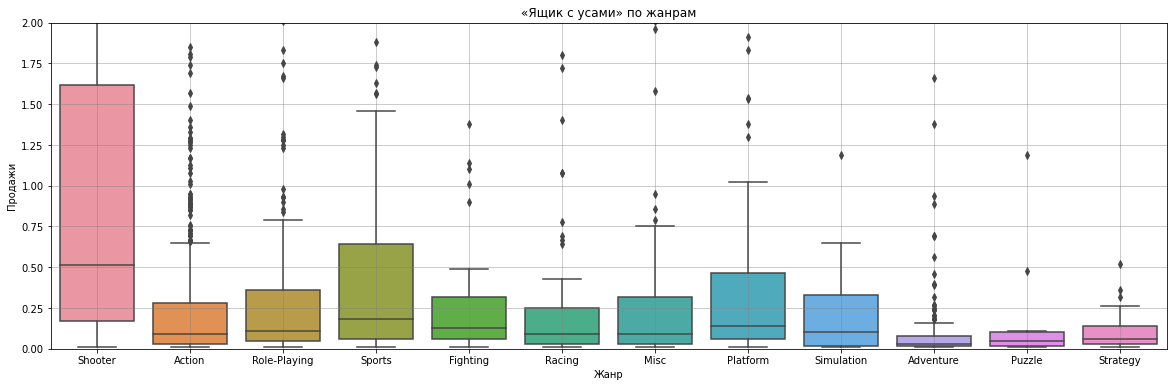

In [50]:
# посмотрим на диаграмму размаха для популярных жанров
plt.figure(figsize=(20, 6))
sns.boxplot(y='total_sales', x='genre', data=games_upd)
plt.title('«Ящик с усами» по жанрам')
plt.grid(color="grey", axis="both", alpha=0.5)
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.ylim(0, 2)
plt.show()


Здесь мы можем сделать вывод, что несмотря на высокие суммарные продажи по некоторым жанрам, нельзя судить о их популярности в целом. Например, жанр экшен был самым прибыльным, но медиана продаж по этому жанру низкая, что говорит об отдельной игре, которая могла выстрелить. Таким образом, устойчивый спрос имеют жанры шутер, спортивные игры и платформер.

## Портрет пользователя каждого региона

### Самые популярные платформы по регионам

Посмотрим на самые популярные платформы в каждом регионе.

In [51]:
# посмотрим на продажи по платформам в Северной Америке
na_pivot = games_upd.pivot_table(
    values="na_sales", index="platform", aggfunc="sum"
).sort_values(by='na_sales', ascending=False).reset_index()
na_pivot['% sales'] = (na_pivot['na_sales']/na_pivot['na_sales'].sum())*100
na_pivot.head()

,platform,na_sales,% sales
0,PS4,98.61,34.714497
1,XOne,81.27,28.610153
2,X360,28.30,9.962684
3,3DS,22.64,7.970147
4,PS3,22.05,7.762445


In [52]:
# посмотрим на продажи по платформам в Европе
eu_pivot = games_upd.pivot_table(
    values="eu_sales", index="platform", aggfunc="sum"
).sort_values(by='eu_sales', ascending=False).reset_index()
eu_pivot['% sales'] = (eu_pivot['eu_sales']/eu_pivot['eu_sales'].sum())*100
eu_pivot.head()

,platform,eu_sales,% sales
0,PS4,130.04,48.041968
1,XOne,46.25,17.086597
2,PS3,25.54,9.435496
3,PC,17.97,6.638836
4,3DS,16.12,5.955372


In [53]:
# посмотрим на продажи по платформам в Японии
jp_pivot = games_upd.pivot_table(
    values="jp_sales", index="platform", aggfunc="sum"
).sort_values(by='jp_sales', ascending=False).reset_index()
jp_pivot['% sales'] = (jp_pivot['jp_sales']/jp_pivot['jp_sales'].sum())*100
jp_pivot.head()

,platform,jp_sales,% sales
0,3DS,44.24,47.523902
1,PS4,15.02,16.134923
2,PSV,14.54,15.619293
3,PS3,11.22,12.052852
4,WiiU,7.31,7.852616


In [54]:
jp_pivot[jp_pivot['platform'] == 'XOne']

,platform,jp_sales,% sales
6,XOne,0.32,0.343753


Таким образом, в Европе и Северной Америке за последние 3 года лидером среди игровых платформ является Sony PlayStation 4, в то время как в Японии эта консоль занимает только второе место. Cамой популярной в Японии является портативная Nintendo 3DS - на нее приходится почти половина всех продаж.

В Европе и Северной Америке также популярной платформой является Xbox One. В Японии на ее долю приходится очень маленький процент продаж, что не дает возможности попасть в топ-5.

### Самые популярные жанры по регионам

Посмотрим теперь, какие жанры популярны в каждом регионе.

In [55]:
# посмотрим на самые популярные жанры в Северной Америке
na_genres = games_upd.pivot_table(
    values="na_sales", index="genre", aggfunc="sum"
).sort_values(by='na_sales', ascending=False).reset_index()
na_genres['% sales'] = (na_genres['na_sales']/na_genres['na_sales'].sum())*100
na_genres.head()

,genre,na_sales,% sales
0,Shooter,79.02,27.818067
1,Action,72.53,25.533338
2,Sports,46.13,16.239527
3,Role-Playing,33.47,11.782722
4,Misc,15.05,5.298176


In [56]:
na_genres[na_genres['genre'] == 'Fighting']

,genre,na_sales,% sales
5,Fighting,12.43,4.375836


In [57]:
# посмотрим на самые популярные жанры в Европе
eu_genres = games_upd.pivot_table(
    values="eu_sales", index="genre", aggfunc="sum"
).sort_values(by='eu_sales', ascending=False).reset_index()
eu_genres['% sales'] = (eu_genres['eu_sales']/eu_genres['eu_sales'].sum())*100
eu_genres.head()

,genre,eu_sales,% sales
0,Action,74.68,27.589774
1,Shooter,65.52,24.205704
2,Sports,45.73,16.894488
3,Role-Playing,28.17,10.407123
4,Racing,14.13,5.220186


In [58]:
eu_genres[eu_genres['genre'] == 'Fighting']

,genre,eu_sales,% sales
8,Fighting,6.69,2.471553


In [59]:
# посмотрим на самые популярные жанры в Японии
jp_genres = games_upd.pivot_table(
    values="jp_sales", index="genre", aggfunc="sum"
).sort_values(by='jp_sales', ascending=False).reset_index()
jp_genres['% sales'] = (jp_genres['jp_sales']/jp_genres['jp_sales'].sum())*100
jp_genres.head()

,genre,jp_sales,% sales
0,Role-Playing,31.16,33.472983
1,Action,29.58,31.775701
2,Fighting,6.37,6.842840
3,Misc,5.61,6.026426
4,Shooter,4.87,5.231496


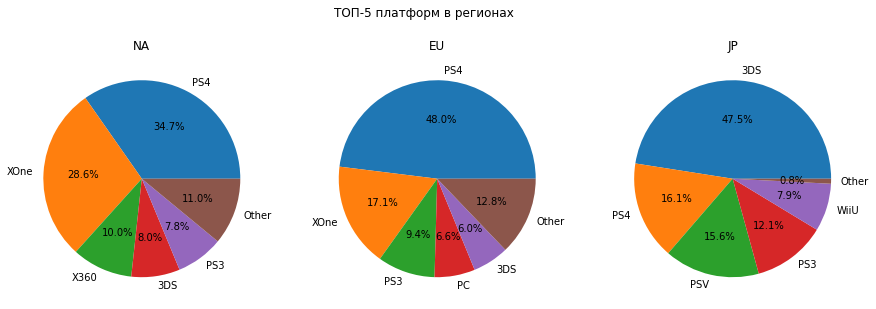

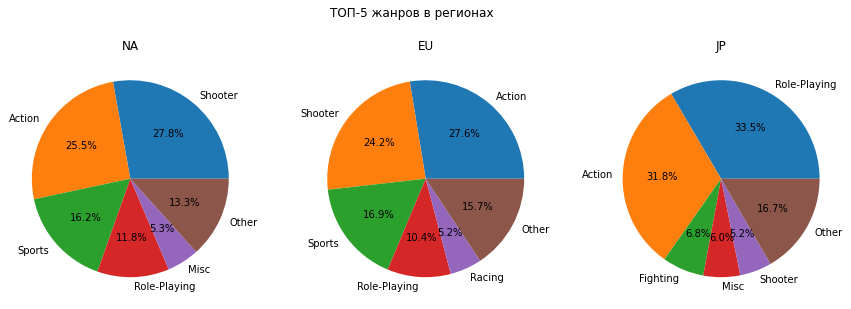

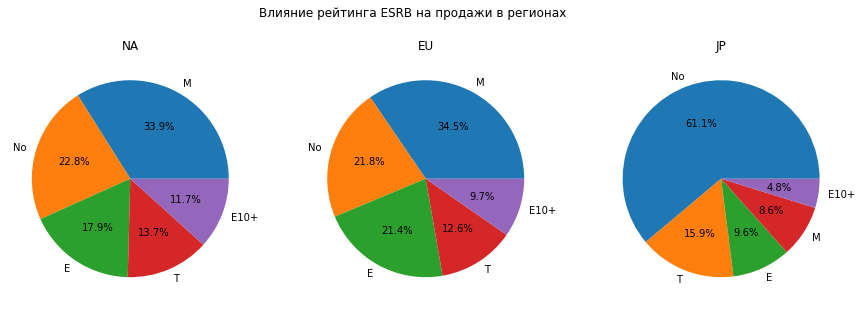

In [60]:
tmp = games_upd.copy()                    # делаем копию текущего датасета, что бы не работать с исходным    
parametr = 'platform'                     # задаем имя колонки для построения диаграмм

def pie_chart(df, parametr = 'platform'): # в функцию передаем датасет и имя колонки платформ/жанров/рейтинга
    region = df.columns[4:7]              # создаем список регионов из названий колонок
                                          # начертим круговую диаграмму для каждого региона
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    if parametr == 'platform':            # будем рисовать диаграммы по платформам
        fig.suptitle('ТОП-5 платформ в регионах')
    elif parametr == 'genre':             # будем рисовать диаграммы по жанрам
        fig.suptitle('ТОП-5 жанров в регионах')
    elif parametr == 'rating':            # будем рисовать диаграммы по возрастному рейтингу
        fig.suptitle('Влияние рейтинга ESRB на продажи в регионах')
    for r in range(len(region)):
      if parametr != 'rating':            # здесь будет формировать топ-5 и группу "другие"
                                          # выберем 5 самых продающих платформ/жанров
        df_r = (df.groupby(parametr)[region[r]].sum().reset_index().
                sort_values(region[r], ascending = False, ignore_index = True)[:5])
                                          # занесем все остальные продажи в другие палатформы/жанры
        df_r = df_r.append({parametr: 'Other', region[r]: df[region[r]].sum() - df_r[region[r]].sum()}, ignore_index= True)
      else:                               # в возрастном рейтинге строим диаграммы по всем значениям
        df_r = (df.groupby(parametr)[region[r]].sum().reset_index().
                sort_values(region[r], ascending = False, ignore_index = True))
        
      axs[r].pie(df_r[region[r]], labels = df_r[parametr], autopct='%1.1f%%')
                                          # зададим название региона.
      axs[r].set_title(df_r.columns[1].split('_')[0].upper())
    plt.show()
    
pie_chart(tmp, parametr)                  # выводим диаграмму
pie_chart(tmp, 'genre')   
pie_chart(tmp, 'rating')   

В популярности жанров мы также видим значимые различия между рынками Северной Америки & Европы и рынком Японии. 

Если тройка лидеров в Северной Америке и Европе совпадает, разница лишь в незначительных расхождениях между жанрами Shooter и Action, которые занимают 1 и 2 место. То в Японии мы видим в первой тройке уже другие жанры, которые здесь наиболее популярны. Первое и второе место делят Role-Playing и Action, а на третьем месте Fighting, который имеет более низкие продажи в Северной Америке и Европе - меньше 5%.

### Влияние рейтинга ESRB на продажи в отдельном регионе

Посмотрим, влияет ли рейтинг ESRB на продажи в отдельном регионе.

In [61]:
rating_stat = (games_upd
                .groupby('rating').sum()
                .sort_values('total_sales', ascending=False)
                [['na_sales', 'eu_sales', 'jp_sales']])
rating_stat /= rating_stat.sum()
rating_stat

,na_sales,eu_sales,jp_sales
rating,,,
M,0.339435,0.345205,0.086046
No,0.227839,0.217785,0.611236
E,0.178624,0.214497,0.096036
T,0.137119,0.125868,0.158771
E10+,0.116982,0.096645,0.047911


Мы видим, что в Северной Америке и Европе самыми популярными играми является игры для взрослой аудитории от 17 лет и старше - рейтинг *М (Mature)* ESRB. В Японии лидируют игры для подростков от 13 лет - рейтинг *Т (Teen)*. Второе место на всех рынках у игр для всех возрастов, то есть *Е (Everyone)*.

Видим, что в Японии больше 60% не имеют рейтинга, а на рынках Северной Америки и Европы игр без рейтинга ESRB - около 20%.

In [62]:
temp = games_upd.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts(dropna=False)

0 0.0


No      749
T       271
M       265
E       219
E10+    185
Name: rating, dtype: int64

Итак, какой портрет можно составить для пользователя каждого региона.


Северная Америка:
- взрослый человек от 17 лет и старше, преимущественно играющий на консоли PS4 в стрелялки.

Европа:
- также взрослый человек от 17 лет и старше, также играющий на PS4, но в экшен.

Япония:
- подросток от 13 лет с портативной приставкой 3DS, который предпочитает ролевую игру, где физические действия игрока рассматриваются как действия персонажа.


## Проверка гипотез

Проверим гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

*Нулевая гипотеза H0*: Средний рейтинг пользователей платформ Xbox One и PC одинаковый. 
*Альтернативная гипотеза H1*: Средний рейтинг пользователей платформ Xbox One и PC разный.

In [63]:
# проведем статистический тест
pc_data = games_upd[games_upd['platform'] == 'PC']

alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(xone_data['user_score'], pc_data['user_score'])

print("p-value:", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: nan
Не получилось отвергнуть нулевую гипотезу


В выборках есть пропуски, очистим данные от пропусков и повторим тест.

In [64]:
xone_data = xone_data.dropna(subset=['user_score'])
pc_data = pc_data.dropna(subset=['user_score'])

alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(xone_data['user_score'], pc_data['user_score'])

print("p-value:", results.pvalue)
print("Средний рейтинг пользователей XOne:", xone_data['user_score'].mean())
print("Средний рейтинг пользователей PC:", pc_data['user_score'].mean())

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 0.10450507919348415
Средний рейтинг пользователей XOne: 6.594545454545456
Средний рейтинг пользователей PC: 6.298360655737705
Не получилось отвергнуть нулевую гипотезу


На имеющихся данных, на уровне значимости 5% нет оснований отвергнуть нулевую гипотезу о том, что средний рейтинги пользователей платформ Xbox One и PC одинаковы.

Проверим другую гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

*H0*: Средние рейтинги пользователей жанров Action и Sports одинаковые. 
*H1*: Средние рейтинги пользователей жанров Action и Sports разные.

In [65]:
action = games_upd[games_upd['genre'] == 'Action'].dropna(subset=['user_score'])
sports = games_upd[games_upd['genre'] == 'Sports'].dropna(subset=['user_score'])

alpha = 0.05  # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(action['user_score'], sports['user_score'])

print("p-value:", results.pvalue)
print("Средний рейтинг пользователей жанров Action:", action['user_score'].mean())
print("Средний рейтинг пользователей жанров Sports:", sports['user_score'].mean())

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-value: 2.8711147985105864e-19
Средний рейтинг пользователей жанров Action: 6.760606060606061
Средний рейтинг пользователей жанров Sports: 5.2251968503937
Отвергаем нулевую гипотезу



На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о том, что средние рейтинги пользователей жанров Action и Sports одинаковые. Средние рейтинги пользователей жанров Action и Sports достаточно разные.


## Выводы

Итак, что удалось сделать в результате проделанной работы:

- проверили данные на наличие пропусков, преобразовали форматы данных, названия столбцов привели к нижнему регистру, заменили значения, которые мешают проведению операций;
- проанализировали данные по годам и пришли к выводу, что последние 3 года являются наиболее подходящими для анализа;
- посчитали глобальные продажи по платформам и определили лидеров - это платформы PS4, XOne и 3DS;
- посмотрели, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков, и выяснили, что увеличение оценки критиков может сопровождаться ростом продаж, но так бывает не всегда, а связи между отзывыми пользователей и продажами вовсе нет;
- посмотрели на общее распределение игр по жанрам и определили, что самыми популярными являются экшен, шутер и спортивные;
- составили общий портрет пользователя для каждого региона:
    -   *для Северной Америки* - взрослый человек от 17 лет и старше, преимущественно играющий на консоли PS4 в стрелялки,
    - *для Европы* - также взрослый человек от 17 лет и старше, также играющий на PS4, но в экшен,
    - *для Японии* - подросток от 13 лет с портативной приставкой 3DS, который предпочитает ролевую игру, где физические действия игрока рассматриваются как действия персонажа;
- проверили пару гипотез и пришли к выводу, что средние рейтинги пользователей платформ Xbox One и PC совпадают, в то время средние пользовательские рейтинги жанров Action и Sports разные, то есть, вероятно, средний рейтинг пользователей более чувствителен к жанру игры, нежели к приставке.


Таким образом, из определяющих факторов в первую очередь стоит назвать рынок, на котором планируется запуск. Ему подчиняются жанр, платформа и целевая аудитория, которая определит успех продукта.